In [35]:
import tensorflow as tf
from tensorflow.keras import layers, losses
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Lambda
from tensorflow.keras import backend as K
from tensorflow.keras.callbacks import TensorBoard
import os
from glob2 import glob
import matplotlib.pyplot as plt
import numpy as np
import cv2
from time import time
import matplotlib.pyplot as plt
from PIL import Image, ImageChops, ImageStat
import diffimg

In [36]:
tf.config.experimental.list_physical_devices('GPU')

[]

In [37]:
train_dir = 'dataset/train_data'
test_dir = 'dataset/test_data'
# an_dir = 'data1/anomal_data/'

In [38]:
image_size = (48, 48)
batch_size = 64
datagen=ImageDataGenerator(rescale=1./ 255)
train_gen = datagen.flow_from_directory(train_dir,
                                        target_size=image_size,
                                        batch_size=batch_size,
                                        color_mode='grayscale',
                                        class_mode='input',
                                        shuffle=True)

test_gen = datagen.flow_from_directory(test_dir,
                                       target_size=image_size,
                                       batch_size=batch_size,
                                       color_mode='grayscale',
                                       class_mode='input')
# an_gen = datagen.flow_from_directory(an_dir,
#                                      target_size=image_size,
#                                      batch_size=batch_size,
#                                      color_mode='grayscale',
#                                      class_mode='input')

Found 411 images belonging to 1 classes.
Found 96 images belonging to 1 classes.


In [59]:
latent_dim = 64 
class Autoencoder(Model):
  def __init__(self, latent_dim):
    super(Autoencoder, self).__init__()
    self.latent_dim = latent_dim   
    self.encoder = tf.keras.Sequential([
      layers.Flatten(),
      layers.Dense(latent_dim, activation='relu'),
    ])
    self.decoder = tf.keras.Sequential([
      layers.Dense(2304, activation='sigmoid'),
      layers.Reshape((48,48,1))
    ])

  def call(self, x):
    encoded = self.encoder(x)
    decoded = self.decoder(encoded)
    return decoded

autoencoder = Autoencoder(latent_dim)
autoencoder.compile(optimizer='adam', loss='MAE',metrics=['accuracy'])
autoencoder.build((64,48,48,1))
autoencoder.summary()

checkpoint_path = "checkpoint/cp.ckpt"

autoencoder.load_weights(checkpoint_path)

cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                 save_weights_only=True,
                                                 verbose=1)


Model: "autoencoder_15"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequential_30 (Sequential)   multiple                  147520    
_________________________________________________________________
sequential_31 (Sequential)   multiple                  149760    
Total params: 297,280
Trainable params: 297,280
Non-trainable params: 0
_________________________________________________________________


ValueError: 

In [60]:
history=autoencoder.fit(train_gen,
                epochs=200,
                batch_size=32,
                shuffle=True,
                validation_data=test_gen,
                callbacks=[tensorboard]
                )

ValueError: The `batch_size` argument must not be specified for the given input type. Received input: <keras_preprocessing.image.directory_iterator.DirectoryIterator object at 0x000001CE5D32CA20>, batch_size: 32

In [53]:
plot1 = plt.figure(1)
plt.plot(history.history['loss'], label='MAE (training data)')
plt.plot(history.history['val_loss'], label='MAE (validation data)')
plt.title('Crossentropy')
plt.ylabel('Crossentropy value')
plt.xlabel('No. epoch')
plt.legend(loc="upper left")

plot2 = plt.figure(2)
plt.plot(history.history['accuracy'], label='binary_crossentropy (training data)')
plt.plot(history.history['val_accuracy'], label='binary_crossentropy (validation data)')
plt.title('Accuracy')
plt.ylabel('Accuracy value')
plt.xlabel('No. epoch')
plt.legend(loc="upper left")

plt.show()

NameError: name 'history' is not defined

<Figure size 432x288 with 0 Axes>

In [54]:
def show_imgs(xs, decoded_imgs):
    n = 10
    plt.figure(figsize=(20, 4))
    for i in range(n):
        # display original
        ax = plt.subplot(2, n, i + 1)
        plt.imshow(xs[i].squeeze())
        plt.title("original")
        plt.gray()
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

        # display reconstruction
        ax = plt.subplot(2, n, i + 1 + n)
        plt.imshow(decoded_imgs[i].squeeze())
        plt.title("reconstructed")
        plt.gray()
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
    plt.show()

xs, ys = next(an_gen)
encoded_imgs = autoencoder.encoder(xs).numpy()
decoded_imgs = autoencoder.decoder(encoded_imgs).numpy()
show_imgs(xs, decoded_imgs)

NameError: name 'an_gen' is not defined

In [10]:
class DeepAutoEncoder(Model):
  def __init__(self):
    super(DeepAutoEncoder, self).__init__()
    self.encoder = tf.keras.Sequential([
      layers.Flatten(),
      layers.Dense(128, activation="relu"),
      layers.Dense(64, activation="relu"),
      layers.Dense(32, activation="relu")])

    self.decoder = tf.keras.Sequential([
      layers.Dense(64, activation="relu"),
      layers.Dense(128, activation="relu"),
      layers.Dense(900, activation="sigmoid"),
      layers.Reshape((30,30,1)),
    ])
    
  def call(self, x):
    encoded = self.encoder(x)
    decoded = self.decoder(encoded)
    return decoded

autoencoder2 = DeepAutoEncoder()
autoencoder2.compile(optimizer='adam', loss='mae')
autoencoder2.build((64,30,30,1))
autoencoder2.summary()

Model: "deep_auto_encoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequential_2 (Sequential)    (64, 32)                  125664    
_________________________________________________________________
sequential_3 (Sequential)    (64, 30, 30, 1)           126532    
Total params: 252,196
Trainable params: 252,196
Non-trainable params: 0
_________________________________________________________________


In [11]:
history=autoencoder2.fit(train_gen,
                epochs=200,
                batch_size=64,
                shuffle=True,
                validation_data=test_gen,
                )

Epoch 1/200
184/184 [==============================] - 3s 16ms/step - loss: 0.2429 - val_loss: 0.2130
Epoch 2/200
184/184 [==============================] - 3s 15ms/step - loss: 0.2098 - val_loss: 0.1988
Epoch 3/200
184/184 [==============================] - 3s 15ms/step - loss: 0.1972 - val_loss: 0.1923
Epoch 4/200
184/184 [==============================] - 3s 16ms/step - loss: 0.1919 - val_loss: 0.1880
Epoch 5/200
184/184 [==============================] - 3s 15ms/step - loss: 0.1877 - val_loss: 0.1845
Epoch 6/200
184/184 [==============================] - 3s 15ms/step - loss: 0.1840 - val_loss: 0.1820
Epoch 7/200
184/184 [==============================] - 3s 15ms/step - loss: 0.1818 - val_loss: 0.1801
Epoch 8/200
184/184 [==============================] - 3s 15ms/step - loss: 0.1801 - val_loss: 0.1786
Epoch 9/200
184/184 [==============================] - 3s 16ms/step - loss: 0.1787 - val_loss: 0.1774
Epoch 10/200
184/184 [==============================] - 3s 15ms/step - loss: 0.177

184/184 [==============================] - 3s 15ms/step - loss: 0.1588 - val_loss: 0.1595
Epoch 160/200
184/184 [==============================] - 3s 15ms/step - loss: 0.1588 - val_loss: 0.1594
Epoch 161/200
184/184 [==============================] - 3s 15ms/step - loss: 0.1588 - val_loss: 0.1593
Epoch 162/200
184/184 [==============================] - 3s 15ms/step - loss: 0.1589 - val_loss: 0.1592
Epoch 163/200
184/184 [==============================] - 3s 15ms/step - loss: 0.1589 - val_loss: 0.1595
Epoch 164/200
184/184 [==============================] - 3s 15ms/step - loss: 0.1588 - val_loss: 0.1593
Epoch 165/200
184/184 [==============================] - 3s 15ms/step - loss: 0.1590 - val_loss: 0.1593
Epoch 166/200
184/184 [==============================] - 3s 15ms/step - loss: 0.1586 - val_loss: 0.1591
Epoch 167/200
184/184 [==============================] - 3s 15ms/step - loss: 0.1584 - val_loss: 0.1594
Epoch 168/200
184/184 [==============================] - 3s 15ms/step - loss: 

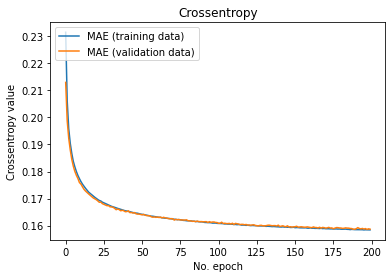

In [12]:
plot1 = plt.figure(1)
plt.plot(history.history['loss'], label='MAE (training data)')
plt.plot(history.history['val_loss'], label='MAE (validation data)')
plt.title('Crossentropy')
plt.ylabel('Crossentropy value')
plt.xlabel('No. epoch')
plt.legend(loc="upper left")


plt.show()

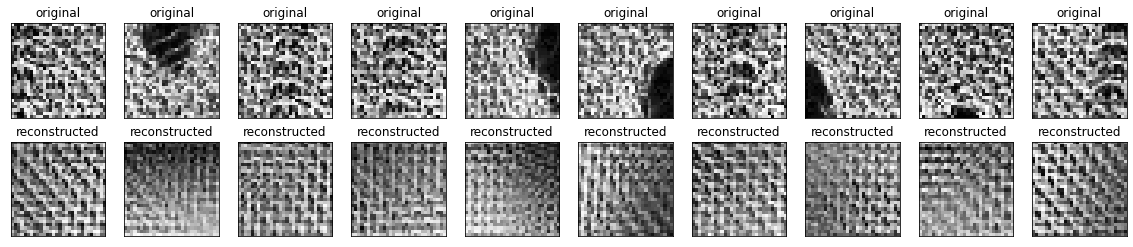

In [13]:
xs, ys = next(an_gen)
encoded_imgs = autoencoder2.encoder(xs).numpy()
decoded_imgs = autoencoder2.decoder(encoded_imgs).numpy()
K.int_shape(decoded_imgs.squeeze())
show_imgs(xs, decoded_imgs)

In [18]:
image_size = (32, 32)
batch_size = 64
datagen=ImageDataGenerator(rescale=1./ 255)
train_gen = datagen.flow_from_directory(train_dir,
                                        target_size=image_size,
                                        batch_size=batch_size,
                                        color_mode='grayscale',
                                        class_mode='input',
                                        shuffle=True)

test_gen = datagen.flow_from_directory(test_dir,
                                       target_size=image_size,
                                       batch_size=batch_size,
                                       color_mode='grayscale',
                                       class_mode='input')
an_gen = datagen.flow_from_directory(an_dir,
                                     target_size=image_size,
                                     batch_size=batch_size,
                                     color_mode='grayscale',
                                     class_mode='input')

Found 11775 images belonging to 1 classes.
Found 2188 images belonging to 1 classes.
Found 196 images belonging to 1 classes.


In [19]:
class convolutional(Model):
    def __init__(self):
        super(convolutional, self).__init__()
        self.encoder = tf.keras.Sequential([
            layers.Conv2D(64, (3, 3), activation='relu', padding='same', strides=2),
            layers.Conv2D(32, (3, 3), activation='relu', padding='same', strides=2),
            layers.Conv2D(16, (3, 3), activation='relu', padding='same', strides=2)])

        self.decoder = tf.keras.Sequential([
           layers.Conv2DTranspose(16, kernel_size=3, strides=2, activation='relu', padding='same'),
           layers.Conv2DTranspose(32, kernel_size=3, strides=2, activation='relu', padding='same'),
           layers.Conv2DTranspose(64, kernel_size=3, strides=2, activation='relu', padding='same'),
           layers.Conv2D(1, kernel_size=(3, 3), activation='sigmoid', padding='same')])

    def call(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded

autoencoder3 = convolutional()
autoencoder3.compile(optimizer='adam', loss='mae')
autoencoder3.build((64,32,32,1))
autoencoder3.summary()

Model: "convolutional_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequential_8 (Sequential)    (64, 4, 4, 16)            23728     
_________________________________________________________________
sequential_9 (Sequential)    (64, 32, 32, 1)           26033     
Total params: 49,761
Trainable params: 49,761
Non-trainable params: 0
_________________________________________________________________


In [20]:
history=autoencoder3.fit(train_gen,
                epochs=200,
                batch_size=64,
                shuffle=True,
                validation_data=test_gen,
                )

Epoch 1/200
184/184 [==============================] - 4s 17ms/step - loss: 0.2350 - val_loss: 0.1618
Epoch 2/200
184/184 [==============================] - 3s 15ms/step - loss: 0.1531 - val_loss: 0.1376
Epoch 3/200
184/184 [==============================] - 3s 15ms/step - loss: 0.1359 - val_loss: 0.1319
Epoch 4/200
184/184 [==============================] - 3s 16ms/step - loss: 0.1307 - val_loss: 0.1283
Epoch 5/200
184/184 [==============================] - 3s 15ms/step - loss: 0.1273 - val_loss: 0.1250
Epoch 6/200
184/184 [==============================] - 3s 16ms/step - loss: 0.1247 - val_loss: 0.1235
Epoch 7/200
184/184 [==============================] - 3s 15ms/step - loss: 0.1227 - val_loss: 0.1218
Epoch 8/200
184/184 [==============================] - 3s 16ms/step - loss: 0.1212 - val_loss: 0.1199
Epoch 9/200
184/184 [==============================] - 3s 16ms/step - loss: 0.1200 - val_loss: 0.1189
Epoch 10/200
184/184 [==============================] - 3s 15ms/step - loss: 0.118

184/184 [==============================] - 3s 15ms/step - loss: 0.1066 - val_loss: 0.1069
Epoch 160/200
184/184 [==============================] - 3s 15ms/step - loss: 0.1066 - val_loss: 0.1069
Epoch 161/200
184/184 [==============================] - 3s 15ms/step - loss: 0.1069 - val_loss: 0.1068
Epoch 162/200
184/184 [==============================] - 3s 15ms/step - loss: 0.1066 - val_loss: 0.1068
Epoch 163/200
184/184 [==============================] - 3s 15ms/step - loss: 0.1067 - val_loss: 0.1071
Epoch 164/200
184/184 [==============================] - 3s 15ms/step - loss: 0.1065 - val_loss: 0.1067
Epoch 165/200
184/184 [==============================] - 3s 15ms/step - loss: 0.1068 - val_loss: 0.1072
Epoch 166/200
184/184 [==============================] - 3s 15ms/step - loss: 0.1068 - val_loss: 0.1069
Epoch 167/200
184/184 [==============================] - 3s 15ms/step - loss: 0.1066 - val_loss: 0.1068
Epoch 168/200
184/184 [==============================] - 3s 15ms/step - loss: 

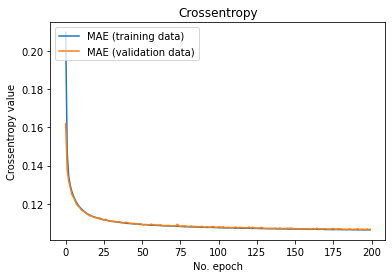

In [21]:
plot1 = plt.figure(1)
plt.plot(history.history['loss'], label='MAE (training data)')
plt.plot(history.history['val_loss'], label='MAE (validation data)')
plt.title('Crossentropy')
plt.ylabel('Crossentropy value')
plt.xlabel('No. epoch')
plt.legend(loc="upper left")


plt.show()

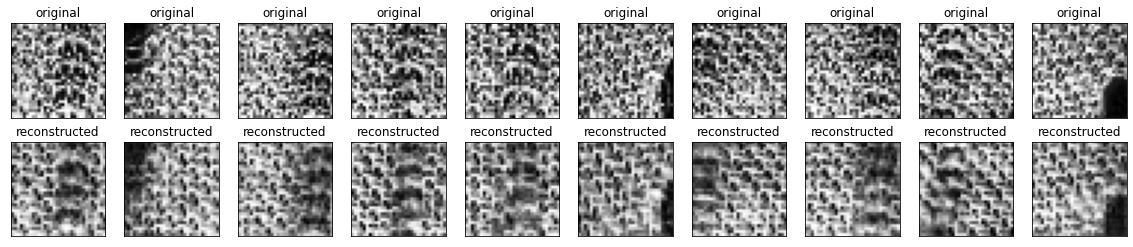

In [24]:
xs, ys = next(an_gen)
encoded_imgs = autoencoder3.encoder(xs).numpy()
decoded_imgs = autoencoder3.decoder(encoded_imgs).numpy()
K.int_shape(decoded_imgs.squeeze())
show_imgs(xs, decoded_imgs)

In [25]:
image_size = (100, 100)
batch_size = 64
datagen=ImageDataGenerator(rescale=1./ 255)
train_gen = datagen.flow_from_directory(train_dir,
                                        target_size=image_size,
                                        batch_size=batch_size,
                                        color_mode='grayscale',
                                        class_mode='input',
                                        shuffle=True)

test_gen = datagen.flow_from_directory(test_dir,
                                       target_size=image_size,
                                       batch_size=batch_size,
                                       color_mode='grayscale',
                                       class_mode='input')
an_gen = datagen.flow_from_directory(an_dir,
                                     target_size=image_size,
                                     batch_size=batch_size,
                                     color_mode='grayscale',
                                     class_mode='input')

Found 11775 images belonging to 1 classes.
Found 2188 images belonging to 1 classes.
Found 196 images belonging to 1 classes.


In [26]:
class CNN(Model):
    def __init__(self):
        super(CNN, self).__init__()
        self.encoder = tf.keras.Sequential([
            layers.Conv2D(8, 3, activation='relu', padding='same', strides=2),
            layers.Conv2D(16, 3, activation='relu'),
            layers.Conv2D(16, 3, activation='relu', padding='same', strides=2),
            layers.Conv2D(16, 3, activation='relu', padding='same', strides=2),
            layers.Conv2D(32, 3, activation='relu', padding='same', strides=2),
            layers.Conv2D(64, 3, activation='relu'),
            layers.Flatten(),
            layers.Dense(256, activation='relu'),
            layers.Dense(128, activation='relu'),
            
        ])

        self.decoder = tf.keras.Sequential([
            layers.Dense(256, activation='relu'),
            layers.Dense(1024, activation='relu'),
            layers.Reshape((4,4,64)),
            layers.Conv2DTranspose(64, 3, activation='relu'),
            layers.Conv2DTranspose(32, 3, strides=2, activation='relu', padding='same'),
            layers.Conv2DTranspose(16, 3, strides=2, activation='relu', padding='same'),
            layers.Conv2DTranspose(16, 3, strides=2, activation='relu', padding='same'),
            layers.Conv2DTranspose(16, 3, activation='relu'),
            layers.Conv2DTranspose(8, 3, strides=2, activation='relu', padding='same'),
            layers.Conv2D(1, 3, activation='relu', padding='same'),
        ])

    def call(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded


autoencoder4= CNN()
autoencoder4.build((64,100,100,1))
autoencoder4.encoder.summary()
autoencoder4.decoder.summary()

Model: "sequential_10"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_12 (Conv2D)           (64, 50, 50, 8)           80        
_________________________________________________________________
conv2d_13 (Conv2D)           (64, 48, 48, 16)          1168      
_________________________________________________________________
conv2d_14 (Conv2D)           (64, 24, 24, 16)          2320      
_________________________________________________________________
conv2d_15 (Conv2D)           (64, 12, 12, 16)          2320      
_________________________________________________________________
conv2d_16 (Conv2D)           (64, 6, 6, 32)            4640      
_________________________________________________________________
conv2d_17 (Conv2D)           (64, 4, 4, 64)            18496     
_________________________________________________________________
flatten_2 (Flatten)          (64, 1024)              

In [27]:
autoencoder4.compile(optimizer='adam', loss='mae')
history=autoencoder4.fit(train_gen,
                epochs=200,
                batch_size=64,
                shuffle=True,
                validation_data=test_gen,
                )

Epoch 1/200
184/184 [==============================] - 4s 20ms/step - loss: 0.3449 - val_loss: 0.2519
Epoch 2/200
184/184 [==============================] - 3s 17ms/step - loss: 0.2499 - val_loss: 0.2471
Epoch 3/200
184/184 [==============================] - 3s 17ms/step - loss: 0.2394 - val_loss: 0.2263
Epoch 4/200
184/184 [==============================] - 3s 17ms/step - loss: 0.2257 - val_loss: 0.2247
Epoch 5/200
184/184 [==============================] - 3s 17ms/step - loss: 0.2245 - val_loss: 0.2242
Epoch 6/200
184/184 [==============================] - 3s 17ms/step - loss: 0.2240 - val_loss: 0.2237
Epoch 7/200
184/184 [==============================] - 3s 17ms/step - loss: 0.2153 - val_loss: 0.1697
Epoch 8/200
184/184 [==============================] - 3s 17ms/step - loss: 0.1655 - val_loss: 0.1547
Epoch 9/200
184/184 [==============================] - 3s 17ms/step - loss: 0.1525 - val_loss: 0.1480
Epoch 10/200
184/184 [==============================] - 3s 17ms/step - loss: 0.146

184/184 [==============================] - 3s 17ms/step - loss: 0.1244 - val_loss: 0.1255
Epoch 160/200
184/184 [==============================] - 3s 17ms/step - loss: 0.1245 - val_loss: 0.1253
Epoch 161/200
184/184 [==============================] - 3s 17ms/step - loss: 0.1244 - val_loss: 0.1251
Epoch 162/200
184/184 [==============================] - 3s 17ms/step - loss: 0.1241 - val_loss: 0.1259
Epoch 163/200
184/184 [==============================] - 3s 17ms/step - loss: 0.1246 - val_loss: 0.1254
Epoch 164/200
184/184 [==============================] - 3s 17ms/step - loss: 0.1242 - val_loss: 0.1251
Epoch 165/200
184/184 [==============================] - 3s 17ms/step - loss: 0.1240 - val_loss: 0.1254
Epoch 166/200
184/184 [==============================] - 3s 17ms/step - loss: 0.1244 - val_loss: 0.1253
Epoch 167/200
184/184 [==============================] - 3s 17ms/step - loss: 0.1244 - val_loss: 0.1252
Epoch 168/200
184/184 [==============================] - 3s 17ms/step - loss: 

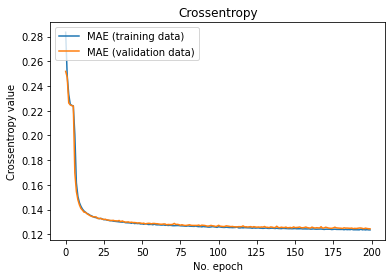

In [28]:
plot1 = plt.figure(1)
plt.plot(history.history['loss'], label='MAE (training data)')
plt.plot(history.history['val_loss'], label='MAE (validation data)')
plt.title('Crossentropy')
plt.ylabel('Crossentropy value')
plt.xlabel('No. epoch')
plt.legend(loc="upper left")


plt.show()

In [19]:
autoencoder4.save('./model/cnn')

INFO:tensorflow:Assets written to: ./model/cnn/assets


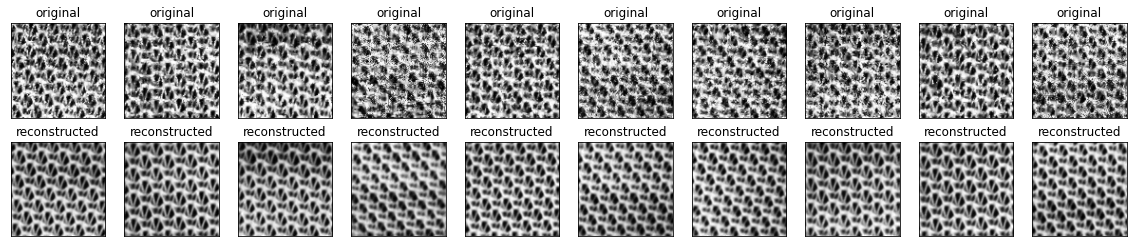

In [35]:
xs, ys = next(test_gen)
encoded_imgs = autoencoder4.encoder(xs).numpy()
decoded_imgs = autoencoder4.decoder(encoded_imgs).numpy()
show_imgs(xs, decoded_imgs)

In [21]:
# %load "test/test.py"  
import cv2
import tensorflow as tf
import numpy as np
from os import listdir
from os.path import join
import time

model = tf.keras.models.load_model('./model/cnn')


def cv2tf_img(img):
    img = np.asarray(img)
    img = np.expand_dims(img, axis=-1)
    img = tf.image.convert_image_dtype(img, tf.float32)
    return img


def is_anomal(r, x, threshold):

    return np.square(r - x).mean() >= threshold


def predict(frame, threshold):
    stride = 50
    size =100
    img = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)

    h, w = img.shape
    num_row = ((h - size) // stride) + 1
    num_col = ((w - size) // stride) + 1

    for i in range(num_row):
        for j in range(num_col):
            eq_img = cv2.equalizeHist(img[i * stride: size + (i * stride), j * stride: size + (j * stride)])
            inp_img = cv2tf_img(eq_img)
            re_img = model.predict(tf.stack([inp_img]))
            if is_anomal(re_img, inp_img, threshold):
                cv2.rectangle(frame, (j * stride, i * stride), (size + (j * stride), size + (i * stride)), (0, 0, 255),
                              -1)

    return frame


if __name__ == '__main__':
    fld = './error/'
    threshold = 0.045
    for i, f in enumerate(listdir(fld)):
        frame = cv2.imread(join(fld, f))
        time_start = time.time()
        frame = predict(frame, threshold)
        time_end = time.time()
        print(f'img-{i} cost time : {time_end - time_start} sec')

        cv2.imwrite(f'./error_result/{i}.bmp', frame)


img-0 cost time : 3.93607497215271 sec
img-1 cost time : 3.633216381072998 sec
img-2 cost time : 3.6122074127197266 sec
img-3 cost time : 3.6576244831085205 sec
img-4 cost time : 3.725982189178467 sec
img-5 cost time : 3.605426549911499 sec
img-6 cost time : 3.6067354679107666 sec
img-7 cost time : 3.59645938873291 sec
img-8 cost time : 3.708847761154175 sec
img-9 cost time : 3.589686155319214 sec
img-10 cost time : 3.6078240871429443 sec


In [63]:
#錯誤比對函數 diff()
im1="error_result/1.jpg"
im2="error/8.jpg"
print(diff(im1,im2))

0.05598240740740741
